# 패키지 다운로드

In [1]:
from geoband.API import *
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import datetime
import folium
import json
import math
from fiona.crs import from_epsg
import numpy as np
from folium.plugins import MarkerCluster
import shapely
import pydeck as pdk
import geopandas as gpd
from shapely.geometry import Polygon, Point
import seaborn as sns
#한글, 마이너스 폰트깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 파일 다운로드

In [2]:
GetCompasData('SBJ_2107_003', '3', '3.부산시남구_주차장현황')
df3 = pd.read_csv('3.부산시남구_주차장현황')
GetCompasData('SBJ_2107_003', '4', '4.부산시남구_건축물대장(표제부).csv')
df4 = pd.read_csv('4.부산시남구_건축물대장(표제부).csv')
GetCompasData('SBJ_2107_003', '6', '6.부산시남구_주택노후도.geojson')
df6 = gpd.read_file("6.부산시남구_주택노후도.geojson")
GetCompasData('SBJ_2107_003', '9', '9.부산시남구_동별_인구정보.csv')
df9 = pd.read_csv('9.부산시남구_동별_인구정보.csv')
GetCompasData('SBJ_2107_003', '10', '10.부산시남구_공시지가.geojson')
df10 = gpd.read_file('10.부산시남구_공시지가.geojson')
GetCompasData('SBJ_2107_003', '11', '11.부산시남구_도로명주소(도로).geojson')
df11 = gpd.read_file("11.부산시남구_도로명주소(도로).geojson")
GetCompasData('SBJ_2107_003', '12', '12.부산시남구_토지이용현황.geojson')
df12 = gpd.read_file("12.부산시남구_토지이용현황.geojson")
GetCompasData('SBJ_2107_003', '15', '15.부산시남구_격자(300X300).geojson')
df15 = gpd.read_file("15.부산시남구_격자(300X300).geojson")

In [3]:
def polygon_to_coordinates(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

In [4]:
#격자
df15['coordinates'] = df15['geometry'].apply(polygon_to_coordinates) 

df15_list = []
for i in df15['geometry']:
    cent = i.centroid
    df15_list.append(cent)
df15['geo_cent'] = 0
df15['geo_cent'] = df15_list 

df15['grid_id']=0
idx = []
for i in range(len(df15)):
    idx.append(str(i).zfill(5))
df15['grid_id'] = pd.DataFrame(idx)

df15

,id,geometry,coordinates,geo_cent,grid_id
0,6,"POLYGON ((129.06301 35.15031, 129.06570 35.150...","[[129.06300949513243, 35.15030633905416], [129...",POINT (129.0643569680586 35.1492045702545),00000
1,7,"POLYGON ((129.06301 35.14810, 129.06570 35.148...","[[129.06300949513243, 35.14810280145483], [129...",POINT (129.0643569680586 35.14700100282101),00001
2,8,"POLYGON ((129.06301 35.14590, 129.06570 35.145...","[[129.06300949513243, 35.14589920418718], [129...",POINT (129.0643569680586 35.14479737572),00002
3,9,"POLYGON ((129.06301 35.14370, 129.06570 35.143...","[[129.06300949513243, 35.14369554725283], [129...",POINT (129.0643569680586 35.14259368895314),00003
4,10,"POLYGON ((129.06301 35.14149, 129.06570 35.141...","[[129.06300949513243, 35.14149183065344], [129...",POINT (129.0643569680586 35.14038994252206),00004
...,...,...,...,...,...
538,860,"POLYGON ((129.12769 35.11945, 129.13038 35.119...","[[129.12768819558906, 35.11945138344417], [129...",POINT (129.1290356685152 35.11834919704105),00538
539,861,"POLYGON ((129.12769 35.11725, 129.13038 35.117...","[[129.12768819558906, 35.11724701063793], [129...",POINT (129.1290356685153 35.11614479441218),00539
540,862,"POLYGON ((129.12769 35.11504, 129.13038 35.115...","[[129.12768819558906, 35.11504257818642], [129...",POINT (129.1290356685152 35.11394033213885),00540
541,863,"POLYGON ((129.12769 35.11284, 129.13038 35.112...","[[129.12768819558906, 35.11283808609127], [129...",POINT (129.1290356685153 35.11173581022271),00541


# 1. 도로 EDA

<BarContainer object of 51 artists>

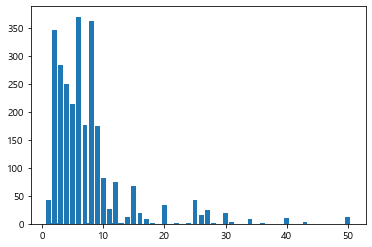

In [5]:
plt.bar(df11['ROAD_BT'].value_counts().index, df11['ROAD_BT'].value_counts().values)

# 2. 노상주차장 후보지선정

- 주차장은 노상주차장과 노외주차장으로 나눌 수 있음.
- 노상주차장을 설치하기 위해서는 일정 조건을 만족해야함
- 하지만 조건을 구체화하기 힘들어 기존 주차장을 참고해야함

In [6]:
#--길'에 해당하는 도로명주소를 가지고 '광역도로'가 아닌 '시군구도로'인 도로 중
#도로 폭이 10미터 이상인 도로에 노상주차장을 설치 고려해야한다.
#소방도로의 경우 공공데이터가 제공되지 않아 필터 불가능
#추가 고려사항 : 상업지역x / 단독주택단지
#추가 고려사항 : 스쿨존 / 건물입구(오피스텔 혹은 원룸건물 같은 경우 1층에 필로티? 주차장이 있어 노상주차장 설치 불가능)

#추가 고려사항은 26게의 도로를 일일이 확인해가며 선정

노상주차장 = df11[(df11['ROA_CLS_SE']=='4')&(df11['WDR_RD_CD']=='3')&(df11['RDS_DPN_SE']=='0')&(df11['ROAD_BT']>=10)]
map노상주차장 = folium.Map(location=[35.12048306804342, 129.09209955486202], zoom_start=13,
                  zoom_control=False, control_scale=True)
folium.GeoJson(노상주차장).add_to(map노상주차장)
map노상주차장

In [51]:
노상주차장설치구역

,BSI_INT,RBP_CN,RDS_DPN_SE,RDS_MAN_NO,REP_CN,RN,ROAD_BT,ROAD_LT,ROA_CLS_SE,WDR_RD_CD,geometry
666,10,남구 문현동 557-15 일원,0,102,남구 문현동 51-25 일원,고동골로97번길,11.000,497.0,4,3,"MULTILINESTRING ((129.07227 35.14554, 129.0722..."
1089,10,감만동 3-81,0,1122,대연동 1170-12,석포로64번길,10.000,413.0,4,3,"MULTILINESTRING ((129.08761 35.12391, 129.0876..."
1560,10,남구 감만동 244-3 일원,0,588,남구 감만동 229-88 일원,양지골로55번길,10.000,318.0,4,3,"MULTILINESTRING ((129.08639 35.11242, 129.0863..."
2044,10,남구 용당동 565-16 일원,0,1300,남구 대연동722-6 일원,유엔평화로143번길,11.767,214.0,4,3,"MULTILINESTRING ((129.09695 35.12361, 129.0970..."
2205,10,남구 문현동 1072-4 일원,0,2467,남구 문현동 1176-3 일원,장고개로63번길,11.000,422.0,4,3,"MULTILINESTRING ((129.07058 35.13091, 129.0704..."
2343,10,남구 문현동 740-10 일원,0,2485,남구 문현동 756-1 일원,전포대로77번길,10.000,290.0,4,3,"MULTILINESTRING ((129.06676 35.14378, 129.0662..."


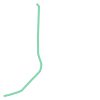

In [50]:
노상주차장설치구역 = 노상주차장.loc[[666, 1089, 1560, 2044, 2205, 2343]]
노상주차장설치구역.iloc[1].geometry

# 최종 노상주차장 후보지

In [8]:
노상주차장설치구역map = folium.Map(location=[35.12048306804342, 129.09209955486202], zoom_start=13,
                  zoom_control=False, control_scale=True)
folium.GeoJson(노상주차장설치구역).add_to(노상주차장설치구역map)
노상주차장설치구역map

In [43]:
노상주차장설치구역['coordinates'] = 노상주차장설치구역['geometry'].apply(multipolygon_to_coordinates) #pydeck 을 위한 coordinate type
노상주차장설치구역

AttributeError: 'LineString' object has no attribute 'exterior'

# 3. 공시지가 EDA

In [9]:
#공시지가가 0인 곳의 정보 제외
df10 = df10[df10['lnd_prc']!=0]
#다른 column으로 이루어진 주소 하나로 변경
df10['emd_nm0'] = df10['emd_nm']+' '+df10['jibun']
#지목(토지의 목적)이 주차장인 곳
df10['jimok_nm'] = df10['jimok'].str[-1]
#구분코드가 일반인 곳만 추출 / 산 제외
df10 = df10[df10['reg_nm']=='일반']

df10 = df10[['emd_nm0','jimok_nm','lnd_prc','geometry','lnd_area']]

#지목을 사용해 주차장 용도로 쓸 수 없는 곳은 제외
df10 = df10[(df10['jimok_nm']=='대')|
(df10['jimok_nm']=='전')|
(df10['jimok_nm']=='잡')|
(df10['jimok_nm']=='임')|
(df10['jimok_nm']=='구')|
(df10['jimok_nm']=='답')|
(df10['jimok_nm']=='장')|
(df10['jimok_nm']=='종')|
(df10['jimok_nm']=='차')|
(df10['jimok_nm']=='창')|
(df10['jimok_nm']=='주')|
(df10['jimok_nm']=='공')|
(df10['jimok_nm']=='체')|
(df10['jimok_nm']=='원')]

#과수원 / 목장용지 / 광천지 / 염전 / 학교 / 도로 / 철도용지 / 제방 / 하천 / 유지 / 양어장 / 수도용지 / 사적지 / 묘지 제외


In [10]:
#중복제거
df10['emd_nm0'] = df10['emd_nm0'].drop_duplicates(keep = 'first')
df10.rename(columns = {'emd_nm0' : 'emd_nm'}, inplace = True)
df10

,emd_nm,jimok_nm,lnd_prc,geometry,lnd_area
0,부산광역시 남구 용호동 562-3,대,1017000,"MULTIPOLYGON (((129.11309 35.10997, 129.11292 ...",0.0
1,부산광역시 남구 용호동 562-4,대,960000,"MULTIPOLYGON (((129.11326 35.11000, 129.11309 ...",0.0
2,부산광역시 남구 용호동 562-2,대,1160000,"MULTIPOLYGON (((129.11307 35.11004, 129.11290 ...",0.0
3,부산광역시 남구 우암동 124,종,726200,"MULTIPOLYGON (((129.07232 35.12728, 129.07236 ...",0.0
6,부산광역시 남구 대연동 202-3,전,564700,"MULTIPOLYGON (((129.09689 35.14459, 129.09687 ...",0.0
...,...,...,...,...,...
45768,부산광역시 남구 감만동 3-434,대,577100,"MULTIPOLYGON (((129.08633 35.11954, 129.08632 ...",0.0
45769,부산광역시 남구 문현동 553-56,대,656100,"MULTIPOLYGON (((129.06992 35.14432, 129.07000 ...",0.0
45772,부산광역시 남구 우암동 189-278,대,542600,"MULTIPOLYGON (((129.06902 35.12687, 129.06903 ...",0.0
45773,부산광역시 남구 우암동 189-1749,대,571200,"MULTIPOLYGON (((129.06855 35.12696, 129.06857 ...",0.0


In [11]:
df10_lnd = df10[df10['lnd_area']!=0]
df10_lnd

,emd_nm,jimok_nm,lnd_prc,geometry,lnd_area
145,부산광역시 남구 대연동 1766-28,대,4400000,"MULTIPOLYGON (((129.08459 35.13550, 129.08460 ...",99.2
154,부산광역시 남구 대연동 1222-236,대,990000,"MULTIPOLYGON (((129.08524 35.13333, 129.08532 ...",213.0
188,부산광역시 남구 대연동 1127-28,대,992000,"MULTIPOLYGON (((129.08957 35.12823, 129.08951 ...",102.0
197,부산광역시 남구 대연동 1463-9,대,1620000,"MULTIPOLYGON (((129.08939 35.13858, 129.08953 ...",144.7
283,부산광역시 남구 대연동 875-3,대,1820000,"MULTIPOLYGON (((129.09448 35.13255, 129.09448 ...",180.2
...,...,...,...,...,...
45584,부산광역시 남구 감만동 92-7,대,660000,"MULTIPOLYGON (((129.07972 35.11737, 129.07980 ...",63.0
45682,부산광역시 남구 용호동 375-62,대,905000,"MULTIPOLYGON (((129.11544 35.11955, 129.11555 ...",143.7
45727,부산광역시 남구 우암동 209-11,종,363700,"MULTIPOLYGON (((129.07266 35.12966, 129.07262 ...",397.0
45746,부산광역시 남구 우암동 194-19,대,1890000,"MULTIPOLYGON (((129.07149 35.12759, 129.07148 ...",231.0


(array([2.970e+02, 9.690e+02, 8.550e+02, 1.033e+03, 4.581e+03, 5.070e+03,
        4.102e+03, 4.164e+03, 1.842e+03, 2.152e+03, 1.469e+03, 9.960e+02,
        7.880e+02, 9.170e+02, 8.760e+02, 9.090e+02, 7.290e+02, 4.510e+02,
        2.860e+02, 2.710e+02, 2.310e+02, 1.870e+02, 1.340e+02, 1.340e+02,
        1.230e+02, 9.800e+01, 1.100e+02, 1.070e+02, 8.000e+01, 1.000e+02,
        4.200e+01, 6.200e+01, 7.800e+01, 5.900e+01, 7.600e+01, 4.300e+01,
        4.400e+01, 2.400e+01, 3.000e+01, 2.300e+01, 3.600e+01, 2.100e+01,
        2.700e+01, 2.100e+01, 2.400e+01, 8.000e+00, 1.300e+01, 2.300e+01,
        3.000e+00, 1.400e+01, 8.000e+00, 1.000e+00, 6.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 5.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.200e+01, 0.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+0

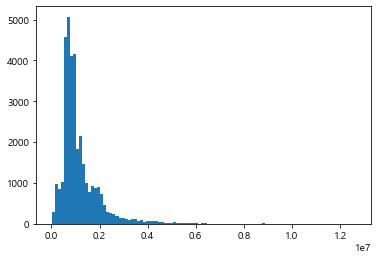

In [12]:
plt.hist(df10['lnd_prc'].values, bins = 100)

In [13]:
df10['coordinates'] = df10['geometry'].apply(multipolygon_to_coordinates) #pydeck 을 위한 coordinate type
df10

,emd_nm,jimok_nm,lnd_prc,geometry,lnd_area,coordinates
0,부산광역시 남구 용호동 562-3,대,1017000,"MULTIPOLYGON (((129.11309 35.10997, 129.11292 ...",0.0,"[[129.11309409828203, 35.109965612327514], [12..."
1,부산광역시 남구 용호동 562-4,대,960000,"MULTIPOLYGON (((129.11326 35.11000, 129.11309 ...",0.0,"[[129.11325978201674, 35.110003551887225], [12..."
2,부산광역시 남구 용호동 562-2,대,1160000,"MULTIPOLYGON (((129.11307 35.11004, 129.11290 ...",0.0,"[[129.1130692504888, 35.11003564408388], [129...."
3,부산광역시 남구 우암동 124,종,726200,"MULTIPOLYGON (((129.07232 35.12728, 129.07236 ...",0.0,"[[129.07231835682296, 35.127278870015836], [12..."
6,부산광역시 남구 대연동 202-3,전,564700,"MULTIPOLYGON (((129.09689 35.14459, 129.09687 ...",0.0,"[[129.09689462315703, 35.14459444246101], [129..."
...,...,...,...,...,...,...
45768,부산광역시 남구 감만동 3-434,대,577100,"MULTIPOLYGON (((129.08633 35.11954, 129.08632 ...",0.0,"[[129.08632752872046, 35.119538234432525], [12..."
45769,부산광역시 남구 문현동 553-56,대,656100,"MULTIPOLYGON (((129.06992 35.14432, 129.07000 ...",0.0,"[[129.06992043670587, 35.14432390975422], [129..."
45772,부산광역시 남구 우암동 189-278,대,542600,"MULTIPOLYGON (((129.06902 35.12687, 129.06903 ...",0.0,"[[129.06902055500805, 35.12686763298422], [129..."
45773,부산광역시 남구 우암동 189-1749,대,571200,"MULTIPOLYGON (((129.06855 35.12696, 129.06857 ...",0.0,"[[129.06855488093714, 35.126961732318954], [12..."


In [14]:
격자별_평균공시지가 = gpd.sjoin(df15, df10, how='left', op='intersects')
격자별_평균공시지가

,id,geometry,coordinates_left,geo_cent,grid_id,index_right,emd_nm,jimok_nm,lnd_prc,lnd_area,coordinates_right
0,6,"POLYGON ((129.06301 35.15031, 129.06570 35.150...","[[129.06300949513243, 35.15030633905416], [129...",POINT (129.0643569680586 35.1492045702545),00000,30115.0,부산광역시 남구 문현동 1227-2,대,4091000.0,0.0,"[[129.06493334603684, 35.14781421019029], [129..."
0,6,"POLYGON ((129.06301 35.15031, 129.06570 35.150...","[[129.06300949513243, 35.15030633905416], [129...",POINT (129.0643569680586 35.1492045702545),00000,45173.0,부산광역시 남구 문현동 1226,대,3702000.0,0.0,"[[129.06357250902852, 35.148244808527664], [12..."
0,6,"POLYGON ((129.06301 35.15031, 129.06570 35.150...","[[129.06300949513243, 35.15030633905416], [129...",POINT (129.0643569680586 35.1492045702545),00000,19539.0,부산광역시 남구 문현동 1227-1,공,2531000.0,0.0,"[[129.0635697365766, 35.14842419789297], [129...."
0,6,"POLYGON ((129.06301 35.15031, 129.06570 35.150...","[[129.06300949513243, 35.15030633905416], [129...",POINT (129.0643569680586 35.1492045702545),00000,22270.0,부산광역시 남구 문현동 697-11,대,1452000.0,0.0,"[[129.06518221313735, 35.149162896468525], [12..."
1,7,"POLYGON ((129.06301 35.14810, 129.06570 35.148...","[[129.06300949513243, 35.14810280145483], [129...",POINT (129.0643569680586 35.14700100282101),00001,30547.0,부산광역시 남구 문현동 1228-5,대,3740000.0,6610.0,"[[129.06360113932683, 35.14636809627632], [129..."
...,...,...,...,...,...,...,...,...,...,...,...
538,860,"POLYGON ((129.12769 35.11945, 129.13038 35.119...","[[129.12768819558906, 35.11945138344417], [129...",POINT (129.1290356685152 35.11834919704105),00538,NaN,NaN,NaN,NaN,NaN,NaN
539,861,"POLYGON ((129.12769 35.11725, 129.13038 35.117...","[[129.12768819558906, 35.11724701063793], [129...",POINT (129.1290356685153 35.11614479441218),00539,NaN,NaN,NaN,NaN,NaN,NaN
540,862,"POLYGON ((129.12769 35.11504, 129.13038 35.115...","[[129.12768819558906, 35.11504257818642], [129...",POINT (129.1290356685152 35.11394033213885),00540,NaN,NaN,NaN,NaN,NaN,NaN
541,863,"POLYGON ((129.12769 35.11284, 129.13038 35.112...","[[129.12768819558906, 35.11283808609127], [129...",POINT (129.1290356685153 35.11173581022271),00541,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
격자별_평균공시지가.drop_duplicates(['id'], inplace=True)
피벗 = 격자별_평균공시지가.pivot_table(index='id',
                 values='lnd_prc',
                 aggfunc='mean',
                    fill_value=0)
격자별_평균공시지가 = pd.merge(격자별_평균공시지가, 피벗, on='id')
격자별_평균공시지가

,id,geometry,coordinates_left,geo_cent,grid_id,index_right,emd_nm,jimok_nm,lnd_prc_x,lnd_area,coordinates_right,lnd_prc_y
0,6,"POLYGON ((129.06301 35.15031, 129.06570 35.150...","[[129.06300949513243, 35.15030633905416], [129...",POINT (129.0643569680586 35.1492045702545),00000,30115.0,부산광역시 남구 문현동 1227-2,대,4091000.0,0.0,"[[129.06493334603684, 35.14781421019029], [129...",4091000
1,7,"POLYGON ((129.06301 35.14810, 129.06570 35.148...","[[129.06300949513243, 35.14810280145483], [129...",POINT (129.0643569680586 35.14700100282101),00001,30547.0,부산광역시 남구 문현동 1228-5,대,3740000.0,6610.0,"[[129.06360113932683, 35.14636809627632], [129...",3740000
2,8,"POLYGON ((129.06301 35.14590, 129.06570 35.145...","[[129.06300949513243, 35.14589920418718], [129...",POINT (129.0643569680586 35.14479737572),00002,11793.0,부산광역시 남구 문현동 755,대,699600.0,0.0,"[[129.06476168138494, 35.14370886167557], [129...",699600
3,9,"POLYGON ((129.06301 35.14370, 129.06570 35.143...","[[129.06300949513243, 35.14369554725283], [129...",POINT (129.0643569680586 35.14259368895314),00003,33111.0,부산광역시 남구 문현동 790-69,대,2277000.0,0.0,"[[129.0654002031807, 35.141529269541664], [129...",2277000
4,10,"POLYGON ((129.06301 35.14149, 129.06570 35.141...","[[129.06300949513243, 35.14149183065344], [129...",POINT (129.0643569680586 35.14038994252206),00004,33111.0,부산광역시 남구 문현동 790-69,대,2277000.0,0.0,"[[129.0654002031807, 35.141529269541664], [129...",2277000
...,...,...,...,...,...,...,...,...,...,...,...,...
444,798,"POLYGON ((129.12230 35.10181, 129.12499 35.101...","[[129.12229830388432, 35.1018147310188], [129....",POINT (129.1236457768105 35.10071230605766),00524,24665.0,부산광역시 남구 용호동 872-2,잡,436800.0,0.0,"[[129.12231580735474, 35.10053624121242], [129...",436800
445,799,"POLYGON ((129.12230 35.09961, 129.12499 35.099...","[[129.12229830388432, 35.09960988109652], [129...",POINT (129.1236457768105 35.09850742631934),00525,18099.0,부산광역시 남구 용호동 937,임,38800.0,0.0,"[[129.1239835550155, 35.09706224399506], [129....",38800
446,800,"POLYGON ((129.12230 35.09740, 129.12499 35.097...","[[129.12229830388432, 35.097404971542154], [12...",POINT (129.1236457768105 35.09630248694976),00526,18099.0,부산광역시 남구 용호동 937,임,38800.0,0.0,"[[129.1239835550155, 35.09706224399506], [129....",38800
447,836,"POLYGON ((129.12499 35.09520, 129.12769 35.095...","[[129.1249932497367, 35.09520000235738], [129....",POINT (129.1263407226629 35.09409748795061),00536,18101.0,부산광역시 남구 용호동 939,임,39900.0,0.0,"[[129.1265971484639, 35.09275853525783], [129....",39900


In [16]:
from sklearn.preprocessing import MinMaxScaler

# 객체 생성 
scaler = MinMaxScaler()

# 모델 fit
mm_scaler = scaler.fit(격자별_평균공시지가[['lnd_prc_x']] )

# 모델 transform
격자별_평균공시지가_std = mm_scaler.transform(격자별_평균공시지가[['lnd_prc_x']])
격자별_평균공시지가['정규화공시지가'] = 격자별_평균공시지가_std
격자별_평균공시지가

,id,geometry,coordinates_left,geo_cent,grid_id,index_right,emd_nm,jimok_nm,lnd_prc_x,lnd_area,coordinates_right,lnd_prc_y,정규화공시지가
0,6,"POLYGON ((129.06301 35.15031, 129.06570 35.150...","[[129.06300949513243, 35.15030633905416], [129...",POINT (129.0643569680586 35.1492045702545),00000,30115.0,부산광역시 남구 문현동 1227-2,대,4091000.0,0.0,"[[129.06493334603684, 35.14781421019029], [129...",4091000,0.513531
1,7,"POLYGON ((129.06301 35.14810, 129.06570 35.148...","[[129.06300949513243, 35.14810280145483], [129...",POINT (129.0643569680586 35.14700100282101),00001,30547.0,부산광역시 남구 문현동 1228-5,대,3740000.0,6610.0,"[[129.06360113932683, 35.14636809627632], [129...",3740000,0.469352
2,8,"POLYGON ((129.06301 35.14590, 129.06570 35.145...","[[129.06300949513243, 35.14589920418718], [129...",POINT (129.0643569680586 35.14479737572),00002,11793.0,부산광역시 남구 문현동 755,대,699600.0,0.0,"[[129.06476168138494, 35.14370886167557], [129...",699600,0.086671
3,9,"POLYGON ((129.06301 35.14370, 129.06570 35.143...","[[129.06300949513243, 35.14369554725283], [129...",POINT (129.0643569680586 35.14259368895314),00003,33111.0,부산광역시 남구 문현동 790-69,대,2277000.0,0.0,"[[129.0654002031807, 35.141529269541664], [129...",2277000,0.285211
4,10,"POLYGON ((129.06301 35.14149, 129.06570 35.141...","[[129.06300949513243, 35.14149183065344], [129...",POINT (129.0643569680586 35.14038994252206),00004,33111.0,부산광역시 남구 문현동 790-69,대,2277000.0,0.0,"[[129.0654002031807, 35.141529269541664], [129...",2277000,0.285211
...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,798,"POLYGON ((129.12230 35.10181, 129.12499 35.101...","[[129.12229830388432, 35.1018147310188], [129....",POINT (129.1236457768105 35.10071230605766),00524,24665.0,부산광역시 남구 용호동 872-2,잡,436800.0,0.0,"[[129.12231580735474, 35.10053624121242], [129...",436800,0.053593
445,799,"POLYGON ((129.12230 35.09961, 129.12499 35.099...","[[129.12229830388432, 35.09960988109652], [129...",POINT (129.1236457768105 35.09850742631934),00525,18099.0,부산광역시 남구 용호동 937,임,38800.0,0.0,"[[129.1239835550155, 35.09706224399506], [129....",38800,0.003499
446,800,"POLYGON ((129.12230 35.09740, 129.12499 35.097...","[[129.12229830388432, 35.097404971542154], [12...",POINT (129.1236457768105 35.09630248694976),00526,18099.0,부산광역시 남구 용호동 937,임,38800.0,0.0,"[[129.1239835550155, 35.09706224399506], [129....",38800,0.003499
447,836,"POLYGON ((129.12499 35.09520, 129.12769 35.095...","[[129.1249932497367, 35.09520000235738], [129....",POINT (129.1263407226629 35.09409748795061),00536,18101.0,부산광역시 남구 용호동 939,임,39900.0,0.0,"[[129.1265971484639, 35.09275853525783], [129....",39900,0.003638


In [17]:
layer = pdk.Layer( 'PolygonLayer', # 사용할 Layer 타입 
                  격자별_평균공시지가, # 시각화에 쓰일 데이터프레임 
                  get_polygon='coordinates_left', # geometry 정보를 담고있는 컬럼 이름 
                  get_fill_color='[0, (정규화공시지가 * 255), 0]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
                  pickable=True, # 지도와 interactive 한 동작 on 
                  auto_highlight=True # 마우스 오버(hover) 시 박스 출력 
                 ) 

# Set the viewport location 
center = [129.09209955486202, 35.12048306804342] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=12
) 


# Render 
map1 = pdk.Deck(layers=[layer], initial_view_state=view_state,
             map_style='mapbox://styles/mapbox/outdoors-v11'
            )

map1 = map1.to_html()
map1

#값이 비어있는 곳들은 산인 경우임
#대연동쪽이 대학가와 번화가가 존재해 땅값이 비싼 모습

/opt/app-root/lib/python3.6/site-packages/pydeck/bindings/deck.py:107: UserWarning: Mapbox API key is not set. This may impact available features of pydeck.
  UserWarning,


# 4. 건물노후도 EDA

In [18]:
GetCompasData('SBJ_2107_003', '6', '6.부산시남구_주택노후도.geojson')
df6 = gpd.read_file("6.부산시남구_주택노후도.geojson")

In [19]:
df6['emd_nm'] = df6['emd_nm']+' '+df6['jibun']
df6['total_flr'] = df6['grd_flr_num']+df6['ugr_flr_num']
df6 = df6[['emd_nm','bd_age','bd_area','grd_flr_num','ugr_flr_num','total_flr','geometry']]
df6['bd_age'] = df6['bd_age'].fillna(0)
df6 = df6[df6['bd_age']!= 0]
df6 = df6[df6['total_flr']!=0]
df6 = df6[df6['bd_area']!=0]

#잘못된 값 정정
df6['bd_age'].loc[1702]=22
df6['bd_age'].loc[18798]=52
df6['bd_age'].loc[19714]=45
df6['bd_age'].loc[14574]=41

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<BarContainer object of 58 artists>

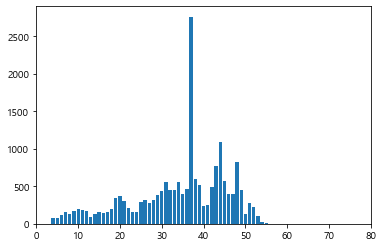

In [20]:
plt.bar(df6['bd_age'].value_counts().index, df6['bd_age'].value_counts().values)

In [21]:
#노후도
df6['coordinates_df6'] = df6['geometry'].apply(multipolygon_to_coordinates)

df6_list = []
for i in df6['geometry']:
    cent = i.centroid
    df6_list.append(cent)
df6['geo_cent'] = 0
df6['geo_cent'] = df6_list
df6

,emd_nm,bd_age,bd_area,grd_flr_num,ugr_flr_num,total_flr,geometry,coordinates_df6,geo_cent
0,부산광역시 남구 대연동 6-5,20.0,1830.380,9,1,10,"MULTIPOLYGON (((129.10670 35.13866, 129.10663 ...","[[129.10670366511812, 35.138656081472135], [12...",POINT (129.106578122565 35.13870415380726)
1,부산광역시 남구 대연동 6-8,10.0,919.730,6,0,6,"MULTIPOLYGON (((129.10617 35.13848, 129.10616 ...","[[129.1061710555118, 35.138475685495735], [129...",POINT (129.1062295234099 35.1384050722337)
2,부산광역시 남구 대연동 6-10,34.0,380.050,5,1,6,"MULTIPOLYGON (((129.10645 35.13865, 129.10638 ...","[[129.10644595928267, 35.1386480040413], [129....",POINT (129.1063758778634 35.1386531097842)
3,부산광역시 남구 대연동 6-27,18.0,386.660,5,0,5,"MULTIPOLYGON (((129.10608 35.13825, 129.10595 ...","[[129.1060830343931, 35.13825428890618], [129....",POINT (129.1059872159712 35.13825186728374)
4,부산광역시 남구 대연동 6-28,9.0,467.205,6,0,6,"MULTIPOLYGON (((129.10619 35.13835, 129.10612 ...","[[129.10618657596527, 35.13835045592473], [129...",POINT (129.1061065211675 35.13834256562341)
...,...,...,...,...,...,...,...,...,...
20529,부산광역시 남구 감만동 48-8,28.0,122.970,2,0,2,"MULTIPOLYGON (((129.08718 35.11682, 129.08716 ...","[[129.0871819107353, 35.11682371630335], [129....",POINT (129.0871143099649 35.11682761539604)
20530,부산광역시 남구 감만동 51-8,48.0,98.080,1,0,1,"MULTIPOLYGON (((129.08554 35.11643, 129.08548 ...","[[129.08553665912373, 35.11642858555347], [129...",POINT (129.0855048820267 35.11652494135335)
20531,부산광역시 남구 감만동 54-1,37.0,52.000,1,0,1,"MULTIPOLYGON (((129.08488 35.11616, 129.08478 ...","[[129.08488362828288, 35.116162450536365], [12...",POINT (129.084830033777 35.11619147659314)
20532,부산광역시 남구 감만동 54-1,37.0,43.180,1,0,1,"MULTIPOLYGON (((129.08507 35.11631, 129.08502 ...","[[129.08507212757783, 35.11630716875537], [129...",POINT (129.0850150459989 35.116321506689)


In [22]:
df6 = gpd.GeoDataFrame(df6, geometry='geo_cent')
df6

,emd_nm,bd_age,bd_area,grd_flr_num,ugr_flr_num,total_flr,geometry,coordinates_df6,geo_cent
0,부산광역시 남구 대연동 6-5,20.0,1830.380,9,1,10,"MULTIPOLYGON (((129.10670 35.13866, 129.10663 ...","[[129.10670366511812, 35.138656081472135], [12...",POINT (129.10658 35.13870)
1,부산광역시 남구 대연동 6-8,10.0,919.730,6,0,6,"MULTIPOLYGON (((129.10617 35.13848, 129.10616 ...","[[129.1061710555118, 35.138475685495735], [129...",POINT (129.10623 35.13841)
2,부산광역시 남구 대연동 6-10,34.0,380.050,5,1,6,"MULTIPOLYGON (((129.10645 35.13865, 129.10638 ...","[[129.10644595928267, 35.1386480040413], [129....",POINT (129.10638 35.13865)
3,부산광역시 남구 대연동 6-27,18.0,386.660,5,0,5,"MULTIPOLYGON (((129.10608 35.13825, 129.10595 ...","[[129.1060830343931, 35.13825428890618], [129....",POINT (129.10599 35.13825)
4,부산광역시 남구 대연동 6-28,9.0,467.205,6,0,6,"MULTIPOLYGON (((129.10619 35.13835, 129.10612 ...","[[129.10618657596527, 35.13835045592473], [129...",POINT (129.10611 35.13834)
...,...,...,...,...,...,...,...,...,...
20529,부산광역시 남구 감만동 48-8,28.0,122.970,2,0,2,"MULTIPOLYGON (((129.08718 35.11682, 129.08716 ...","[[129.0871819107353, 35.11682371630335], [129....",POINT (129.08711 35.11683)
20530,부산광역시 남구 감만동 51-8,48.0,98.080,1,0,1,"MULTIPOLYGON (((129.08554 35.11643, 129.08548 ...","[[129.08553665912373, 35.11642858555347], [129...",POINT (129.08550 35.11652)
20531,부산광역시 남구 감만동 54-1,37.0,52.000,1,0,1,"MULTIPOLYGON (((129.08488 35.11616, 129.08478 ...","[[129.08488362828288, 35.116162450536365], [12...",POINT (129.08483 35.11619)
20532,부산광역시 남구 감만동 54-1,37.0,43.180,1,0,1,"MULTIPOLYGON (((129.08507 35.11631, 129.08502 ...","[[129.08507212757783, 35.11630716875537], [129...",POINT (129.08502 35.11632)


In [23]:
격자노후도 = gpd.sjoin(df15, df6, how='inner', op='intersects')
격자노후도

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  """Entry point for launching an IPython kernel.


,id,geometry_left,coordinates,geo_cent,grid_id,index_right,emd_nm,bd_age,bd_area,grd_flr_num,ugr_flr_num,total_flr,geometry_right,coordinates_df6
2,8,"POLYGON ((129.06301 35.14590, 129.06570 35.145...","[[129.06300949513243, 35.14589920418718], [129...",POINT (129.0643569680586 35.14479737572),00002,15419,부산광역시 남구 문현동 743-9,7.0,22.5200,1,0,1,"MULTIPOLYGON (((129.06515 35.14382, 129.06513 ...","[[129.0651482070469, 35.143815605164555], [129..."
2,8,"POLYGON ((129.06301 35.14590, 129.06570 35.145...","[[129.06300949513243, 35.14589920418718], [129...",POINT (129.0643569680586 35.14479737572),00002,15423,부산광역시 남구 문현동 743-22,50.0,46.2800,2,0,2,"MULTIPOLYGON (((129.06532 35.14382, 129.06525 ...","[[129.06531961332334, 35.143815244186044], [12..."
2,8,"POLYGON ((129.06301 35.14590, 129.06570 35.145...","[[129.06300949513243, 35.14589920418718], [129...",POINT (129.0643569680586 35.14479737572),00002,15414,부산광역시 남구 문현동 742-15,51.0,66.1200,2,0,2,"MULTIPOLYGON (((129.06557 35.14382, 129.06550 ...","[[129.06556570787808, 35.14381911638727], [129..."
2,8,"POLYGON ((129.06301 35.14590, 129.06570 35.145...","[[129.06300949513243, 35.14589920418718], [129...",POINT (129.0643569680586 35.14479737572),00002,15409,부산광역시 남구 문현동 742-6,48.0,130.7500,3,0,3,"MULTIPOLYGON (((129.06549 35.14381, 129.06534 ...","[[129.06549317976018, 35.143814143253735], [12..."
2,8,"POLYGON ((129.06301 35.14590, 129.06570 35.145...","[[129.06300949513243, 35.14589920418718], [129...",POINT (129.0643569680586 35.14479737572),00002,15420,부산광역시 남구 문현동 743-12,37.0,27.9500,1,0,1,"MULTIPOLYGON (((129.06525 35.14390, 129.06525 ...","[[129.06525201427456, 35.143897240621776], [12..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,762,"POLYGON ((129.11960 35.10402, 129.12230 35.104...","[[129.11960335803198, 35.10401952130735], [129...",POINT (129.1209508309582 35.10291712616308),00507,10915,부산광역시 남구 용호동 944,14.0,4209.9271,2,1,3,"MULTIPOLYGON (((129.12025 35.10332, 129.12032 ...","[[129.12025159603306, 35.1033153539534], [129...."
507,762,"POLYGON ((129.11960 35.10402, 129.12230 35.104...","[[129.11960335803198, 35.10401952130735], [129...",POINT (129.1209508309582 35.10291712616308),00507,10921,부산광역시 남구 용호동 944,14.0,43085.0093,45,0,45,"MULTIPOLYGON (((129.11990 35.10352, 129.12001 ...","[[129.11989798441297, 35.10351866009231], [129..."
507,762,"POLYGON ((129.11960 35.10402, 129.12230 35.104...","[[129.11960335803198, 35.10401952130735], [129...",POINT (129.1209508309582 35.10291712616308),00507,10919,부산광역시 남구 용호동 944,14.0,39894.4192,39,0,39,"MULTIPOLYGON (((129.12185 35.10370, 129.12182 ...","[[129.1218459145582, 35.10369595894591], [129...."
524,798,"POLYGON ((129.12230 35.10181, 129.12499 35.101...","[[129.12229830388432, 35.1018147310188], [129....",POINT (129.1236457768105 35.10071230605766),00524,10931,부산광역시 남구 용호동 950-1,10.0,368.6900,2,0,2,"MULTIPOLYGON (((129.12299 35.10162, 129.12309 ...","[[129.1229936328531, 35.101615360883756], [129..."


In [24]:
격자노후도.drop_duplicates(['id'], inplace=True)
피벗_노후도 = 격자노후도.pivot_table(index='id',
                 values='bd_age',
                 aggfunc='mean',
                    fill_value=0)
격자별_평균노후도 = pd.merge(격자노후도, 피벗_노후도, on='id')
격자별_평균노후도

,id,geometry_left,coordinates,geo_cent,grid_id,index_right,emd_nm,bd_age_x,bd_area,grd_flr_num,ugr_flr_num,total_flr,geometry_right,coordinates_df6,bd_age_y
0,8,"POLYGON ((129.06301 35.14590, 129.06570 35.145...","[[129.06300949513243, 35.14589920418718], [129...",POINT (129.0643569680586 35.14479737572),00002,15419,부산광역시 남구 문현동 743-9,7.0,22.5200,1,0,1,"MULTIPOLYGON (((129.06515 35.14382, 129.06513 ...","[[129.0651482070469, 35.143815605164555], [129...",7
1,9,"POLYGON ((129.06301 35.14370, 129.06570 35.143...","[[129.06300949513243, 35.14369554725283], [129...",POINT (129.0643569680586 35.14259368895314),00003,15751,부산광역시 남구 문현동 790-23,24.0,149.1400,3,0,3,"MULTIPOLYGON (((129.06555 35.14154, 129.06543 ...","[[129.06555291588793, 35.14154159161233], [129...",24
2,10,"POLYGON ((129.06301 35.14149, 129.06570 35.141...","[[129.06300949513243, 35.14149183065344], [129...",POINT (129.0643569680586 35.14038994252206),00004,15761,부산광역시 남구 문현동 791,36.0,9.5100,1,0,1,"MULTIPOLYGON (((129.06514 35.14126, 129.06512 ...","[[129.06514197914103, 35.14125841178137], [129...",36
3,41,"POLYGON ((129.06570 35.15031, 129.06840 35.150...","[[129.0657044409848, 35.15030633905416], [129....",POINT (129.067051913911 35.1492045702545),00010,15247,부산광역시 남구 문현동 617-65,26.0,193.3600,3,0,3,"MULTIPOLYGON (((129.06833 35.14807, 129.06828 ...","[[129.06833331825177, 35.148065472602894], [12...",26
4,42,"POLYGON ((129.06570 35.14810, 129.06840 35.148...","[[129.0657044409848, 35.14810280145483], [129....",POINT (129.067051913911 35.14700100282101),00011,15117,부산광역시 남구 문현동 599,28.0,222.3500,4,0,4,"MULTIPOLYGON (((129.06835 35.14591, 129.06831 ...","[[129.06835383098286, 35.14590861350529], [129...",28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,749,"POLYGON ((129.11960 35.13268, 129.12230 35.132...","[[129.11960335803198, 35.13267636763835], [129...",POINT (129.1209508309582 35.13157436018838),00494,7135,부산광역시 남구 용호동 5-4,10.0,5277.1000,3,2,5,"MULTIPOLYGON (((129.12070 35.13126, 129.12061 ...","[[129.1207031282075, 35.131258998406295], [129...",10
329,761,"POLYGON ((129.11960 35.10622, 129.12230 35.106...","[[129.11960335803198, 35.106224251960526], [12...",POINT (129.1209508309582 35.10512188663394),00506,10912,부산광역시 남구 용호동 944,14.0,35071.4244,42,0,42,"MULTIPOLYGON (((129.11996 35.10429, 129.11997 ...","[[129.11995647335777, 35.1042892768262], [129....",14
330,762,"POLYGON ((129.11960 35.10402, 129.12230 35.104...","[[129.11960335803198, 35.10401952130735], [129...",POINT (129.1209508309582 35.10291712616308),00507,10922,부산광역시 남구 용호동 944,14.0,24593.6242,24,0,24,"MULTIPOLYGON (((129.12056 35.10209, 129.12064 ...","[[129.12055756086178, 35.1020858828733], [129....",14
331,798,"POLYGON ((129.12230 35.10181, 129.12499 35.101...","[[129.12229830388432, 35.1018147310188], [129....",POINT (129.1236457768105 35.10071230605766),00524,10931,부산광역시 남구 용호동 950-1,10.0,368.6900,2,0,2,"MULTIPOLYGON (((129.12299 35.10162, 129.12309 ...","[[129.1229936328531, 35.101615360883756], [129...",10


In [25]:
from sklearn.preprocessing import MinMaxScaler

# 객체 생성 
scaler = MinMaxScaler()

# 모델 fit
mm_scaler = scaler.fit(격자별_평균노후도[['bd_age_x']] )

# 모델 transform
격자평균노후도_std = mm_scaler.transform(격자별_평균노후도[['bd_age_x']])
격자별_평균노후도['정규화노후도'] = 격자평균노후도_std
격자별_평균노후도

,id,geometry_left,coordinates,geo_cent,grid_id,index_right,emd_nm,bd_age_x,bd_area,grd_flr_num,ugr_flr_num,total_flr,geometry_right,coordinates_df6,bd_age_y,정규화노후도
0,8,"POLYGON ((129.06301 35.14590, 129.06570 35.145...","[[129.06300949513243, 35.14589920418718], [129...",POINT (129.0643569680586 35.14479737572),00002,15419,부산광역시 남구 문현동 743-9,7.0,22.5200,1,0,1,"MULTIPOLYGON (((129.06515 35.14382, 129.06513 ...","[[129.0651482070469, 35.143815605164555], [129...",7,0.061224
1,9,"POLYGON ((129.06301 35.14370, 129.06570 35.143...","[[129.06300949513243, 35.14369554725283], [129...",POINT (129.0643569680586 35.14259368895314),00003,15751,부산광역시 남구 문현동 790-23,24.0,149.1400,3,0,3,"MULTIPOLYGON (((129.06555 35.14154, 129.06543 ...","[[129.06555291588793, 35.14154159161233], [129...",24,0.408163
2,10,"POLYGON ((129.06301 35.14149, 129.06570 35.141...","[[129.06300949513243, 35.14149183065344], [129...",POINT (129.0643569680586 35.14038994252206),00004,15761,부산광역시 남구 문현동 791,36.0,9.5100,1,0,1,"MULTIPOLYGON (((129.06514 35.14126, 129.06512 ...","[[129.06514197914103, 35.14125841178137], [129...",36,0.653061
3,41,"POLYGON ((129.06570 35.15031, 129.06840 35.150...","[[129.0657044409848, 35.15030633905416], [129....",POINT (129.067051913911 35.1492045702545),00010,15247,부산광역시 남구 문현동 617-65,26.0,193.3600,3,0,3,"MULTIPOLYGON (((129.06833 35.14807, 129.06828 ...","[[129.06833331825177, 35.148065472602894], [12...",26,0.448980
4,42,"POLYGON ((129.06570 35.14810, 129.06840 35.148...","[[129.0657044409848, 35.14810280145483], [129....",POINT (129.067051913911 35.14700100282101),00011,15117,부산광역시 남구 문현동 599,28.0,222.3500,4,0,4,"MULTIPOLYGON (((129.06835 35.14591, 129.06831 ...","[[129.06835383098286, 35.14590861350529], [129...",28,0.489796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,749,"POLYGON ((129.11960 35.13268, 129.12230 35.132...","[[129.11960335803198, 35.13267636763835], [129...",POINT (129.1209508309582 35.13157436018838),00494,7135,부산광역시 남구 용호동 5-4,10.0,5277.1000,3,2,5,"MULTIPOLYGON (((129.12070 35.13126, 129.12061 ...","[[129.1207031282075, 35.131258998406295], [129...",10,0.122449
329,761,"POLYGON ((129.11960 35.10622, 129.12230 35.106...","[[129.11960335803198, 35.106224251960526], [12...",POINT (129.1209508309582 35.10512188663394),00506,10912,부산광역시 남구 용호동 944,14.0,35071.4244,42,0,42,"MULTIPOLYGON (((129.11996 35.10429, 129.11997 ...","[[129.11995647335777, 35.1042892768262], [129....",14,0.204082
330,762,"POLYGON ((129.11960 35.10402, 129.12230 35.104...","[[129.11960335803198, 35.10401952130735], [129...",POINT (129.1209508309582 35.10291712616308),00507,10922,부산광역시 남구 용호동 944,14.0,24593.6242,24,0,24,"MULTIPOLYGON (((129.12056 35.10209, 129.12064 ...","[[129.12055756086178, 35.1020858828733], [129....",14,0.204082
331,798,"POLYGON ((129.12230 35.10181, 129.12499 35.101...","[[129.12229830388432, 35.1018147310188], [129....",POINT (129.1236457768105 35.10071230605766),00524,10931,부산광역시 남구 용호동 950-1,10.0,368.6900,2,0,2,"MULTIPOLYGON (((129.12299 35.10162, 129.12309 ...","[[129.1229936328531, 35.101615360883756], [129...",10,0.122449


In [26]:
layer = pdk.Layer( 'PolygonLayer', # 사용할 Layer 타입 
                  격자별_평균노후도, # 시각화에 쓰일 데이터프레임 
                  get_polygon='coordinates', # geometry 정보를 담고있는 컬럼 이름 
                  get_fill_color='[0, (정규화노후도 * 255), 0]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
                  pickable=True, # 지도와 interactive 한 동작 on 
                  auto_highlight=True # 마우스 오버(hover) 시 박스 출력 
                 ) 

# Set the viewport location 
center = [129.09209955486202, 35.12048306804342] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=12
) 


# Render 
map2 = pdk.Deck(layers=[layer], initial_view_state=view_state,
             map_style='mapbox://styles/mapbox/outdoors-v11'
            )

map2 = map2.to_html()
map2

#값이 비어있는 곳들은 산인 경우임
#대연동쪽이 대학가와 번화가가 존재해 땅값이 비싼 모습

/opt/app-root/lib/python3.6/site-packages/pydeck/bindings/deck.py:107: UserWarning: Mapbox API key is not set. This may impact available features of pydeck.
  UserWarning,


# 5. 격자별 주차가능면수 계산

In [27]:
df6 = df6[(df6['bd_age']>=43)&(df6['grd_flr_num']<3)]
df6

,emd_nm,bd_age,bd_area,grd_flr_num,ugr_flr_num,total_flr,geometry,coordinates_df6,geo_cent
50,부산광역시 남구 대연동 30-2,48.0,58.880,2,0,2,"MULTIPOLYGON (((129.10583 35.13902, 129.10575 ...","[[129.10583321375125, 35.13901629601229], [129...",POINT (129.10578 35.13902)
68,부산광역시 남구 대연동 30-27,44.0,138.610,2,1,3,"MULTIPOLYGON (((129.10549 35.13888, 129.10545 ...","[[129.10549410982367, 35.13887936465404], [129...",POINT (129.10542 35.13890)
70,부산광역시 남구 대연동 30-29,43.0,128.330,2,0,2,"MULTIPOLYGON (((129.10543 35.13859, 129.10538 ...","[[129.10542609554557, 35.13859050234064], [129...",POINT (129.10540 35.13863)
72,부산광역시 남구 대연동 30-34,44.0,118.670,2,0,2,"MULTIPOLYGON (((129.10551 35.13886, 129.10556 ...","[[129.10550635191393, 35.13885874906125], [129...",POINT (129.10549 35.13880)
85,부산광역시 남구 대연동 31-12,49.0,154.705,2,0,2,"MULTIPOLYGON (((129.10556 35.13813, 129.10550 ...","[[129.1055604926712, 35.13812716072337], [129....",POINT (129.10550 35.13816)
...,...,...,...,...,...,...,...,...,...
20520,부산광역시 남구 감만동 39-11,45.0,54.150,1,0,1,"MULTIPOLYGON (((129.08455 35.11717, 129.08454 ...","[[129.084550097036, 35.11717186123959], [129.0...",POINT (129.08449 35.11716)
20521,부산광역시 남구 감만동 39-13,45.0,60.830,1,0,1,"MULTIPOLYGON (((129.08487 35.11717, 129.08486 ...","[[129.08487370440412, 35.11716693388023], [129...",POINT (129.08481 35.11715)
20523,부산광역시 남구 감만동 39-24,43.0,84.630,1,1,2,"MULTIPOLYGON (((129.08513 35.11731, 129.08501 ...","[[129.0851297533021, 35.11730634246922], [129....",POINT (129.08506 35.11733)
20525,부산광역시 남구 감만동 43-14,44.0,55.640,1,0,1,"MULTIPOLYGON (((129.08624 35.11746, 129.08633 ...","[[129.08624422035604, 35.117461926536954], [12...",POINT (129.08626 35.11741)


In [28]:
df10_lnd = df10[df10['lnd_area']!=0]
df10_lnd

,emd_nm,jimok_nm,lnd_prc,geometry,lnd_area,coordinates
145,부산광역시 남구 대연동 1766-28,대,4400000,"MULTIPOLYGON (((129.08459 35.13550, 129.08460 ...",99.2,"[[129.08459139267447, 35.135495396402796], [12..."
154,부산광역시 남구 대연동 1222-236,대,990000,"MULTIPOLYGON (((129.08524 35.13333, 129.08532 ...",213.0,"[[129.0852437076362, 35.13332851350544], [129...."
188,부산광역시 남구 대연동 1127-28,대,992000,"MULTIPOLYGON (((129.08957 35.12823, 129.08951 ...",102.0,"[[129.08957107024804, 35.12822879046451], [129..."
197,부산광역시 남구 대연동 1463-9,대,1620000,"MULTIPOLYGON (((129.08939 35.13858, 129.08953 ...",144.7,"[[129.08939178808677, 35.13857762712917], [129..."
283,부산광역시 남구 대연동 875-3,대,1820000,"MULTIPOLYGON (((129.09448 35.13255, 129.09448 ...",180.2,"[[129.09448162420594, 35.132545956794516], [12..."
...,...,...,...,...,...,...
45584,부산광역시 남구 감만동 92-7,대,660000,"MULTIPOLYGON (((129.07972 35.11737, 129.07980 ...",63.0,"[[129.07971683715522, 35.11736734790867], [129..."
45682,부산광역시 남구 용호동 375-62,대,905000,"MULTIPOLYGON (((129.11544 35.11955, 129.11555 ...",143.7,"[[129.1154359747613, 35.11954652572871], [129...."
45727,부산광역시 남구 우암동 209-11,종,363700,"MULTIPOLYGON (((129.07266 35.12966, 129.07262 ...",397.0,"[[129.07265876368263, 35.12966224334851], [129..."
45746,부산광역시 남구 우암동 194-19,대,1890000,"MULTIPOLYGON (((129.07149 35.12759, 129.07148 ...",231.0,"[[129.0714876840732, 35.12759466602372], [129...."


In [29]:
주차장입지선정_3 = pd.merge(df10_lnd, df6, how = 'inner', on = 'emd_nm')
주차장입지선정_3

,emd_nm,jimok_nm,lnd_prc,geometry_x,lnd_area,coordinates,bd_age,bd_area,grd_flr_num,ugr_flr_num,total_flr,geometry_y,coordinates_df6,geo_cent
0,부산광역시 남구 대연동 1222-236,대,990000,"MULTIPOLYGON (((129.08524 35.13333, 129.08532 ...",213.0,"[[129.0852437076362, 35.13332851350544], [129....",49.0,95.20,2,0,2,"MULTIPOLYGON (((129.08520 35.13334, 129.08522 ...","[[129.085203113783, 35.13334178284509], [129.0...",POINT (129.08521 35.13329)
1,부산광역시 남구 대연동 1127-28,대,992000,"MULTIPOLYGON (((129.08957 35.12823, 129.08951 ...",102.0,"[[129.08957107024804, 35.12822879046451], [129...",48.0,52.56,1,0,1,"MULTIPOLYGON (((129.08947 35.12833, 129.08951 ...","[[129.0894723052716, 35.12833057136746], [129....",POINT (129.08949 35.12826)
2,부산광역시 남구 감만동 29-149,대,730000,"MULTIPOLYGON (((129.08789 35.12298, 129.08781 ...",73.0,"[[129.0878879974194, 35.12298127554629], [129....",45.0,43.54,1,0,1,"MULTIPOLYGON (((129.08784 35.12300, 129.08788 ...","[[129.08784005083334, 35.12299808408399], [129...",POINT (129.08782 35.12296)
3,부산광역시 남구 감만동 288-7,대,1400000,"MULTIPOLYGON (((129.08147 35.11306, 129.08153 ...",164.0,"[[129.08147424894668, 35.11306371324419], [129...",45.0,136.66,1,1,2,"MULTIPOLYGON (((129.08151 35.11298, 129.08143 ...","[[129.08151021441847, 35.11298211683501], [129...",POINT (129.08146 35.11301)
4,부산광역시 남구 대연동 54-22,대,4590000,"MULTIPOLYGON (((129.10233 35.13814, 129.10238 ...",175.2,"[[129.1023252653607, 35.138141263622934], [129...",48.0,224.33,2,0,2,"MULTIPOLYGON (((129.10238 35.13807, 129.10227 ...","[[129.10238150628288, 35.138065196176825], [12...",POINT (129.10230 35.13808)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,부산광역시 남구 문현동 13-12,대,934000,"MULTIPOLYGON (((129.07310 35.14687, 129.07324 ...",109.0,"[[129.0731001706522, 35.14686558324879], [129....",53.0,52.23,1,0,1,"MULTIPOLYGON (((129.07324 35.14685, 129.07323 ...","[[129.07324335454368, 35.14684921145928], [129...",POINT (129.07319 35.14682)
225,부산광역시 남구 감만동 38-15,대,2280000,"MULTIPOLYGON (((129.08661 35.12327, 129.08667 ...",107.0,"[[129.08660545585624, 35.12326580594958], [129...",47.0,128.26,2,0,2,"MULTIPOLYGON (((129.08667 35.12323, 129.08661 ...","[[129.0866655535532, 35.12323368358569], [129....",POINT (129.08659 35.12323)
226,부산광역시 남구 감만동 206-103,대,1180000,"MULTIPOLYGON (((129.08460 35.11409, 129.08461 ...",118.0,"[[129.08459986672426, 35.11409361511859], [129...",44.0,119.72,2,0,2,"MULTIPOLYGON (((129.08459 35.11399, 129.08452 ...","[[129.08458885812598, 35.11399054241975], [129...",POINT (129.08457 35.11404)
227,부산광역시 남구 문현동 13-86,대,915000,"MULTIPOLYGON (((129.07278 35.14612, 129.07293 ...",119.0,"[[129.07278361195773, 35.14611666127292], [129...",51.0,119.27,2,0,2,"MULTIPOLYGON (((129.07296 35.14611, 129.07296 ...","[[129.0729561053064, 35.14611230571313], [129....",POINT (129.07290 35.14608)


In [30]:
주차장입지선정_4 = pd.merge(df10_lnd, df6, how = 'left', on = 'emd_nm')
주차장입지선정_4.drop_duplicates('emd_nm', inplace = True)
주차장입지선정_4 = 주차장입지선정_4[주차장입지선정_4['jimok_nm']!='대']
주차장입지선정_4

,emd_nm,jimok_nm,lnd_prc,geometry_x,lnd_area,coordinates,bd_age,bd_area,grd_flr_num,ugr_flr_num,total_flr,geometry_y,coordinates_df6,geo_cent
108,부산광역시 남구 대연동 1623-196,전,140000,"MULTIPOLYGON (((129.08010 35.13117, 129.08012 ...",238.0,"[[129.08010227578737, 35.131174358564145], [12...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
212,부산광역시 남구 용당동 128-6,장,770000,"MULTIPOLYGON (((129.09870 35.11672, 129.09891 ...",10455.0,"[[129.09870018886113, 35.11671790993996], [129...",47.0,1846.71,1.0,0.0,1.0,"MULTIPOLYGON (((129.09841 35.11559, 129.09829 ...","[[129.09840667258928, 35.11559172327823], [129...",POINT (129.09807 35.11582)
223,부산광역시 남구 우암동 112-61,전,350000,"MULTIPOLYGON (((129.07809 35.12850, 129.07829 ...",298.0,"[[129.07808544115315, 35.128495305325075], [12...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
355,부산광역시 남구 대연동 39-9,차,2580000,"MULTIPOLYGON (((129.10269 35.13828, 129.10277 ...",114.8,"[[129.10269000300065, 35.138277045690366], [12...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
388,부산광역시 남구 용당동 128-9,잡,1310000,"MULTIPOLYGON (((129.09563 35.11622, 129.09562 ...",8182.0,"[[129.09562760098177, 35.116217295803175], [12...",47.0,3485.73,2.0,0.0,2.0,"MULTIPOLYGON (((129.09649 35.11682, 129.09614 ...","[[129.09649349145286, 35.1168221989419], [129....",POINT (129.09605 35.11694)
392,부산광역시 남구 용당동 162-1,주,1460000,"MULTIPOLYGON (((129.09584 35.11396, 129.09590 ...",1246.0,"[[129.0958358052004, 35.113960133904676], [129...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
464,부산광역시 남구 감만동 239-33,장,1180000,"MULTIPOLYGON (((129.08810 35.11135, 129.08813 ...",365.0,"[[129.08809654751175, 35.111353513862994], [12...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
576,부산광역시 남구 문현동 1047,전,114000,"MULTIPOLYGON (((129.07170 35.13279, 129.07173 ...",354.0,"[[129.07170083102636, 35.13278868940117], [129...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
583,부산광역시 남구 용당동 100-8,잡,746100,"MULTIPOLYGON (((129.09956 35.11698, 129.09996 ...",1866.0,"[[129.0995635336942, 35.116978725841804], [129...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
605,부산광역시 남구 용당동 206-34,장,830000,"MULTIPOLYGON (((129.09043 35.10977, 129.09042 ...",23297.0,"[[129.09042543004801, 35.109770883010235], [12...",NaN,NaN,NaN,NaN,NaN,None,NaN,None


In [31]:
주차장입지선정_4 = 주차장입지선정_4[주차장입지선정_4['bd_area'].isna()]
주차장입지선정_4

,emd_nm,jimok_nm,lnd_prc,geometry_x,lnd_area,coordinates,bd_age,bd_area,grd_flr_num,ugr_flr_num,total_flr,geometry_y,coordinates_df6,geo_cent
108,부산광역시 남구 대연동 1623-196,전,140000,"MULTIPOLYGON (((129.08010 35.13117, 129.08012 ...",238.0,"[[129.08010227578737, 35.131174358564145], [12...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
223,부산광역시 남구 우암동 112-61,전,350000,"MULTIPOLYGON (((129.07809 35.12850, 129.07829 ...",298.0,"[[129.07808544115315, 35.128495305325075], [12...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
355,부산광역시 남구 대연동 39-9,차,2580000,"MULTIPOLYGON (((129.10269 35.13828, 129.10277 ...",114.8,"[[129.10269000300065, 35.138277045690366], [12...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
392,부산광역시 남구 용당동 162-1,주,1460000,"MULTIPOLYGON (((129.09584 35.11396, 129.09590 ...",1246.0,"[[129.0958358052004, 35.113960133904676], [129...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
464,부산광역시 남구 감만동 239-33,장,1180000,"MULTIPOLYGON (((129.08810 35.11135, 129.08813 ...",365.0,"[[129.08809654751175, 35.111353513862994], [12...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
576,부산광역시 남구 문현동 1047,전,114000,"MULTIPOLYGON (((129.07170 35.13279, 129.07173 ...",354.0,"[[129.07170083102636, 35.13278868940117], [129...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
583,부산광역시 남구 용당동 100-8,잡,746100,"MULTIPOLYGON (((129.09956 35.11698, 129.09996 ...",1866.0,"[[129.0995635336942, 35.116978725841804], [129...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
605,부산광역시 남구 용당동 206-34,장,830000,"MULTIPOLYGON (((129.09043 35.10977, 129.09042 ...",23297.0,"[[129.09042543004801, 35.109770883010235], [12...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
640,부산광역시 남구 문현동 53-172,임,64200,"MULTIPOLYGON (((129.07717 35.14614, 129.07719 ...",428.0,"[[129.07717027072073, 35.14614057190188], [129...",NaN,NaN,NaN,NaN,NaN,None,NaN,None
652,부산광역시 남구 감만동 521-10,창,770000,"MULTIPOLYGON (((129.07898 35.11025, 129.07945 ...",13495.0,"[[129.07897537445842, 35.110253529559444], [12...",NaN,NaN,NaN,NaN,NaN,None,NaN,None


In [32]:
주차장입지선정xx = pd.concat([주차장입지선정_3, 주차장입지선정_4], axis = 0)
주차장입지선정xx = 주차장입지선정xx[['emd_nm','jimok_nm','lnd_prc','geometry_x','lnd_area','bd_age','geometry_y']]
주차장입지선정xx

,emd_nm,jimok_nm,lnd_prc,geometry_x,lnd_area,bd_age,geometry_y
0,부산광역시 남구 대연동 1222-236,대,990000,"MULTIPOLYGON (((129.08524 35.13333, 129.08532 ...",213.0,49.0,"MULTIPOLYGON (((129.08520 35.13334, 129.08522 ..."
1,부산광역시 남구 대연동 1127-28,대,992000,"MULTIPOLYGON (((129.08957 35.12823, 129.08951 ...",102.0,48.0,"MULTIPOLYGON (((129.08947 35.12833, 129.08951 ..."
2,부산광역시 남구 감만동 29-149,대,730000,"MULTIPOLYGON (((129.08789 35.12298, 129.08781 ...",73.0,45.0,"MULTIPOLYGON (((129.08784 35.12300, 129.08788 ..."
3,부산광역시 남구 감만동 288-7,대,1400000,"MULTIPOLYGON (((129.08147 35.11306, 129.08153 ...",164.0,45.0,"MULTIPOLYGON (((129.08151 35.11298, 129.08143 ..."
4,부산광역시 남구 대연동 54-22,대,4590000,"MULTIPOLYGON (((129.10233 35.13814, 129.10238 ...",175.2,48.0,"MULTIPOLYGON (((129.10238 35.13807, 129.10227 ..."
...,...,...,...,...,...,...,...
1052,부산광역시 남구 용당동 570-1,차,1130000,"MULTIPOLYGON (((129.09821 35.12418, 129.09821 ...",599.0,NaN,None
1054,부산광역시 남구 용당동 460-2,주,2255000,"MULTIPOLYGON (((129.09862 35.12022, 129.09863 ...",1898.0,NaN,None
1070,부산광역시 남구 감만동 8-12,잡,1240000,"MULTIPOLYGON (((129.08141 35.12105, 129.08230 ...",9753.0,NaN,None
1077,부산광역시 남구 우암동 189-2008,전,655000,"MULTIPOLYGON (((129.06993 35.12897, 129.06996 ...",175.0,NaN,None


In [33]:
df10_list0 = []
for i in 주차장입지선정xx['geometry_x']:
    cent = i.centroid
    df10_list0.append(cent)
주차장입지선정xx['geo_cent'] = 0
주차장입지선정xx['geo_cent'] = df10_list0
from shapely.geometry import Point
gdf = gpd.GeoDataFrame(주차장입지선정xx, geometry='geometry_x', crs={'init': 'epsg:4326'})
주차장입지 = gpd.sjoin(df15, gdf, how='left', op='intersects')
주차장입지

/opt/app-root/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,id,geometry,coordinates,geo_cent_left,grid_id,index_right,emd_nm,jimok_nm,lnd_prc,lnd_area,bd_age,geometry_y,geo_cent_right
0,6,"POLYGON ((129.06301 35.15031, 129.06570 35.150...","[[129.06300949513243, 35.15030633905416], [129...",POINT (129.0643569680586 35.1492045702545),00000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
1,7,"POLYGON ((129.06301 35.14810, 129.06570 35.148...","[[129.06300949513243, 35.14810280145483], [129...",POINT (129.0643569680586 35.14700100282101),00001,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
2,8,"POLYGON ((129.06301 35.14590, 129.06570 35.145...","[[129.06300949513243, 35.14589920418718], [129...",POINT (129.0643569680586 35.14479737572),00002,69.0,부산광역시 남구 문현동 756-1,대,2770000.0,208.3,49.0,"MULTIPOLYGON (((129.06384 35.14371, 129.06384 ...",POINT (129.0637450587808 35.14364505952805)
3,9,"POLYGON ((129.06301 35.14370, 129.06570 35.143...","[[129.06300949513243, 35.14369554725283], [129...",POINT (129.0643569680586 35.14259368895314),00003,30.0,부산광역시 남구 문현동 788-2,대,2400000.0,146.8,51.0,"MULTIPOLYGON (((129.06491 35.14182, 129.06476 ...",POINT (129.0648179722608 35.14180990194806)
3,9,"POLYGON ((129.06301 35.14370, 129.06570 35.143...","[[129.06300949513243, 35.14369554725283], [129...",POINT (129.0643569680586 35.14259368895314),00003,194.0,부산광역시 남구 문현동 783-10,대,4400000.0,45.7,54.0,"MULTIPOLYGON (((129.06482 35.14269, 129.06482 ...",POINT (129.06472484114 35.14264729447601)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,860,"POLYGON ((129.12769 35.11945, 129.13038 35.119...","[[129.12768819558906, 35.11945138344417], [129...",POINT (129.1290356685152 35.11834919704105),00538,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
539,861,"POLYGON ((129.12769 35.11725, 129.13038 35.117...","[[129.12768819558906, 35.11724701063793], [129...",POINT (129.1290356685153 35.11614479441218),00539,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
540,862,"POLYGON ((129.12769 35.11504, 129.13038 35.115...","[[129.12768819558906, 35.11504257818642], [129...",POINT (129.1290356685152 35.11394033213885),00540,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
541,863,"POLYGON ((129.12769 35.11284, 129.13038 35.112...","[[129.12768819558906, 35.11283808609127], [129...",POINT (129.1290356685153 35.11173581022271),00541,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


In [34]:
주차장입지.groupby('id',as_index=False)['lnd_area'].sum()['lnd_area']

0        0.0
1        0.0
2      208.3
3      474.8
4        0.0
       ...  
538      0.0
539      0.0
540      0.0
541      0.0
542      0.0
Name: lnd_area, Length: 543, dtype: float64

In [35]:
df15['면적합계']= 주차장입지.groupby('id',as_index=False)['lnd_area'].sum()['lnd_area']
df15['가능주차면수'] = df15['면적합계'] / 30

In [36]:
mf = [9, 77, 84, 112, 113, 118, 147, 151, 188,  226, 227, 291, 298, 299, 301, 302, 331, 
      333, 406, 580, 616, 618, 648, 651, 652, 654, 683, 684, 685, 687, 720]
df_mine = df15[df15.id.isin(mf)]

In [37]:
df_mine = df_mine[df_mine['가능주차면수']!=0]

In [38]:
rlt46=pd.read_csv('최종데이터/최종_1차회귀_46개.csv')

In [39]:
df_mine['필요주차면수']=np.nan

In [40]:
df_mine['필요주차면수'] = rlt46['필요주차면수'].values

In [41]:
df_mine

,id,geometry,coordinates,geo_cent,grid_id,면적합계,가능주차면수,필요주차면수
3,9,"POLYGON ((129.06301 35.14370, 129.06570 35.143...","[[129.06300949513243, 35.14369554725283], [129...",POINT (129.0643569680586 35.14259368895314),00003,474.8,15.826667,926.824147
27,77,"POLYGON ((129.06840 35.14810, 129.07109 35.148...","[[129.06839938683717, 35.14810280145483], [129...",POINT (129.0697468597633 35.14700100282101),00027,112.0,3.733333,168.985306
34,84,"POLYGON ((129.06840 35.13268, 129.07109 35.132...","[[129.06839938683717, 35.13267636763835], [129...",POINT (129.0697468597633 35.13157436018838),00034,97.0,3.233333,109.937163
48,112,"POLYGON ((129.07109 35.14810, 129.07379 35.148...","[[129.0710943326895, 35.14810280145483], [129....",POINT (129.0724418056157 35.14700100282101),00048,378.0,12.600000,247.665310
49,113,"POLYGON ((129.07109 35.14590, 129.07379 35.145...","[[129.0710943326895, 35.14589920418718], [129....",POINT (129.0724418056157 35.14479737572),00049,147.0,4.900000,103.164415
54,118,"POLYGON ((129.07109 35.13488, 129.07379 35.134...","[[129.0710943326895, 35.134880322881465], [129...",POINT (129.0724418056157 35.13377834525991),00054,354.0,11.800000,196.233922
70,147,"POLYGON ((129.07379 35.14810, 129.07648 35.148...","[[129.07378927854188, 35.14810280145483], [129...",POINT (129.0751367514681 35.14700100282101),00070,1746.0,58.200000,1388.733962
74,151,"POLYGON ((129.07379 35.13929, 129.07648 35.139...","[[129.07378927854188, 35.13928805439066], [129...",POINT (129.0751367514681 35.13818613642838),00074,200.0,6.666667,75.357833
99,188,"POLYGON ((129.07648 35.13488, 129.07918 35.134...","[[129.07648422439425, 35.134880322881465], [12...",POINT (129.0778316973204 35.13377834525991),00099,695.0,23.166667,515.421204
175,291,"POLYGON ((129.08457 35.13929, 129.08726 35.139...","[[129.08456906195133, 35.13928805439066], [129...",POINT (129.0859165348775 35.13818613642838),00175,424.6,14.153333,220.397984
